In [1]:
# import dask.config as dc
import dask.array as da
import numpy as np
import rioxarray
import xarray as xr
import glob
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
import pandas as pd
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from PyStemmusScope import variable_conversion as vc

# CO2 data: from NetCDF to Zarr

The Carbon Dioxide (CO2) dataset is provided as chunked NetCDF4/HDF5 data. We reproject the spatial extend to match the ERA5 land dataset using rioxarray, which, unfortunately does not support Dask. It is global.

## Input variables

In [2]:
year = 2015

In [3]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
SSM_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/co2/'
)
OUT_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/co2'
)

In [4]:
ERA5_PATH = (
    f'{ROOT_DIR}/francesco/Projects/EcoExtreML/Data/'
    f'1input_data/{2015}global/era5land/era5land.zarr'
)

## Converting the dataset

We start by loading the ERA5-land Zarr dataset, which we will use as the target for reprojection: 

In [5]:
ds = xr.open_zarr(ERA5_PATH)

In [6]:
ds = ds.rio.write_crs('WGS84')
target = ds['sp'].isel(time=0, drop=True)#.sel(longitude=slice(0,60), latitude=slice(80, 35))

We now open the SSM geotiff files. NOTE: we do not set chunks in the spatial dimension because we need to load all values anyway to perform the reprojection. 

In [7]:
co2_paths = sorted(
    glob.glob(f'{SSM_DIR}/*2003-2020*.nc')
)

In [8]:
co2_paths

['/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/co2/CAMS_CO2_2003-2020.nc']

In [9]:
co2 = xr.open_dataset(co2_paths[0]).sel(time=str(year))
co2 = vc.co2_mass_fraction_to_kg_per_m3(co2['co2'])*1e6

In [10]:
# co2 = co2[0:11,:]

We make sure the CRS is in place  and reproject!

In [11]:
co2 = co2.rio.write_crs('EPSG:4326')#.sel(longitude=slice(0,60), latitude=slice(82, 35))
target = target.rio.write_crs('EPSG:4326')
co2.rio.write_nodata(co2.rio.nodata, inplace=True)
co2_reprojected = co2.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan)
co2_reprojected = co2_reprojected.assign_coords({
    "x": co2_reprojected.x,
    "y": co2_reprojected.y,
    'time':('time',co2_reprojected.time.values + np.timedelta64(3,'h'),co2_reprojected.time.attrs) # convert from starting time to ending time, same as ERA5Land
})
co2_reprojected = co2_reprojected.rename({'x':'longitude','y':'latitude'})

In [12]:
co2_reprojected

<xarray.DataArray 'co2' (time: 2920, latitude: 1801, longitude: 3600)>
array([[[797.0952 , 797.0952 , 797.0952 , ..., 797.0952 , 797.0952 ,
         797.0952 ],
        [797.0952 , 797.0952 , 797.0952 , ..., 797.0952 , 797.0952 ,
         797.0952 ],
        [797.0952 , 797.0952 , 797.0952 , ..., 797.0952 , 797.0952 ,
         797.0952 ],
        ...,
        [775.4902 , 775.4902 , 775.4902 , ..., 775.4902 , 775.4902 ,
         775.4902 ],
        [775.4902 , 775.4902 , 775.4902 , ..., 775.4902 , 775.4902 ,
         775.4902 ],
        [775.4902 , 775.4902 , 775.4902 , ..., 775.4902 , 775.4902 ,
         775.4902 ]],

       [[796.6187 , 796.6187 , 796.6187 , ..., 796.6187 , 796.6187 ,
         796.6187 ],
        [796.6187 , 796.6187 , 796.6187 , ..., 796.6187 , 796.6187 ,
         796.6187 ],
        [796.6187 , 796.6187 , 796.6187 , ..., 796.6187 , 796.6187 ,
         796.6187 ],
...
        [780.57367, 780.57367, 780.57367, ..., 780.57367, 780.57367,
         780.57367],
        [780.57367, 780.57367, 780.57367, ..., 780.57367, 780.57367,
         780.57367],
        [780.57367, 780.57367, 780.57367, ..., 780.57367, 780.57367,
         780.57367]],

       [[798.525  , 798.525  , 798.525  , ..., 798.525  , 798.525  ,
         798.525  ],
        [798.525  , 798.525  , 798.525  , ..., 798.525  , 798.525  ,
         798.525  ],
        [798.525  , 798.525  , 798.525  , ..., 798.525  , 798.525  ,
         798.525  ],
        ...,
        [780.4149 , 780.4149 , 780.4149 , ..., 780.4149 , 780.4149 ,
         780.4149 ],
        [780.4149 , 780.4149 , 780.4149 , ..., 780.4149 , 780.4149 ,
         780.4149 ],
        [780.4149 , 780.4149 , 780.4149 , ..., 780.4149 , 780.4149 ,
         780.4149 ]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time         (time) datetime64[ns] 2015-01-01T03:00:00 ... 2016-01-01
    spatial_ref  int64 0
Attributes:
    _FillValue:  nan

In [17]:
# co2_reprojected[0,:].sel(
#     latitude=slice(80, 35),  # 根据南北边界裁剪# 根据南北边界裁剪
#     longitude=slice(0, 60)  # 根据西东边界裁剪
# ).mean()

<xarray.DataArray 'co2' ()>
array(803.4196, dtype=float32)
Coordinates:
    time         datetime64[ns] 2014-01-01T03:00:00
    spatial_ref  int64 0

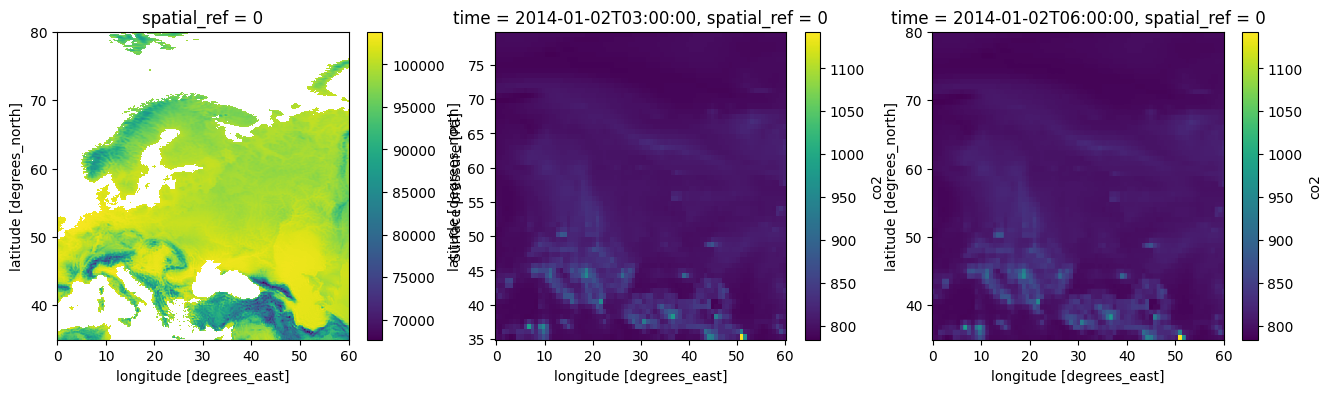

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

target.plot(ax=axes[0])
co2[-1,::].plot(ax=axes[1])
co2_reprojected[-1,::].plot(ax=axes[2])
plt.draw()

We rechunk and save it as Zarr:

In [13]:
co2_reprojected = co2_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
co2_reprojected = co2_reprojected.to_dataset(name='co2')

In [14]:
%%time
zarr_path = f'{OUT_DIR}/co2.zarr'
co2_reprojected.to_zarr(zarr_path, mode='w')

CPU times: user 1min 50s, sys: 48 s, total: 2min 38s
Wall time: 11.5 s


When done with the conversion we switch off the cluster to release resources:

In [15]:
!du -h $zarr_path

2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/co2/co2.zarr/spatial_ref
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/co2/co2.zarr/longitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/co2/co2.zarr/latitude
4.9G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/co2/co2.zarr/co2
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/co2/co2.zarr/time
4.9G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/co2/co2.zarr


In [25]:
xr.open_zarr(zarr_path).co2[0,:].sel(
    latitude=slice(80, 35),  # 根据南北边界裁剪# 根据南北边界裁剪
    longitude=slice(0, 60)  # 根据西东边界裁剪
).mean().compute()

<xarray.DataArray 'co2' ()>
array(803.41943, dtype=float32)
Coordinates:
    time     datetime64[ns] 2014-01-01T03:00:00